# Multiple Traveling Salesman Problem

### Mathematical Problem




In this notebook, we show how to solve the Multiple Traveling Salesman Problem (mTSP) using CVXPY. The problem considers $m$ traveling salesmen. To solve it, I'm going to use the Miller-Tucker-Zemlin formulation, which follows:

The cities are identified with the numbers $1, \ldots, n$, with which we define:

$$
x_{ij} = \begin{cases} 1 & \text{the path goes from the city} \, i \text{ to city } j \\ 0 & \text{otherwise} \end{cases}
$$

For $i = 1, \ldots, n$, $m$ is the number of salesmen, $u_{i}$ is an auxiliary variable and $c_{i, j}$ is the distance from city $i$ to the city $j$. Then the mTSP can be written as the following integer linear programming problem:

$$
\begin{align}
\min &\sum_{i=1}^n \sum_{j\ne i,j=1}^n c_{i,j}x_{i,j}\colon &&  \\
     & \sum_{i=2}^n x_{i,1} = m \\
     & \sum_{j=2}^n x_{1,j} = m \\
     & \sum_{i=2,i\ne j}^n x_{i,j} = 1 && j=1, \ldots, n; \\
     & \sum_{j=2,j\ne i}^n x_{i,j} = 1 && i=1, \ldots, n; \\
     & u_{i}-u_{j} + 1 \le (n-1)(1-x_{i,j}) && 2 \le i \ne j \le n;  \\
     & 0 \le u_{i} \le n && 2 \le i \le n; \\
     & x_{i,j} \in \{0,1\}  && i,j=1, \ldots, n; \\
     & u_{i} \in \mathbf{Z} && i=2, \ldots, n. \\
\end{align}
$$

The objective function minimizes the distance of each salesman's routes. The first two restrictions guarantee that there is a number of salesmen $m$ who leave and return to the city of origin. The following two restrictions ensure that each city is reached from exactly one other city and that from each city there is an exit to exactly one other city. The constraints of the auxiliary variables force that no salesman passes through the same city twice.


### Import necessary libraries

In [ ]:
!pip install --quiet geopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
from geopy import distance 

## Example for a single Traveling Salesman

We are going to find the optimal paths (shortest distance) for a single salesman that starts from the point of origin (O) and must pass through all points A to F and return to point O.

| Point |	Coordinates |
| :----------: | :----------: |
| Origin(O) | (-12.059296, -76.975893) |
| A | (-12.079575, -77.009686) |
| B | (-12.087303, -76.996620) |
| C | (-12.084391, -76.975651) |
| D | (-12.063603, -76.960483) |
| E | (-12.056762, -77.014452) |
| F | (-12.011531, -77.002383) |

In [ ]:
# Original Data

points = [(-12.059296, -76.975893),
          (-12.079575, -77.009686),
          (-12.087303, -76.996620),
          (-12.084391, -76.975651),
          (-12.063603, -76.960483),
          (-12.056762, -77.014452),
          (-12.011531, -77.002383)]

# Building distance matrix (Euclidian)

n = len(points)
C = np.zeros((n,n))

for i in range(0, n):
    for j in range(0, len(points)):
        C[i,j] = distance.distance(points[i], points[j]).km

# Showing distance matrix
print('Distance Matrix is:\n')
print(np.round(C,4))

Distance Matrix is:

[[0.     4.3092 3.8329 2.7762 1.7441 4.2076 6.0199]
 [4.3092 0.     1.6596 3.7435 5.6408 2.5764 7.5691]
 [3.8329 1.6596 0.     2.3055 4.7278 3.8966 8.4056]
 [2.7762 3.7435 2.3055 0.     2.8311 5.2142 8.5694]
 [1.7441 5.6408 4.7278 2.8311 0.     5.9246 7.3483]
 [4.2076 2.5764 3.8966 5.2142 5.9246 0.     5.1733]
 [6.0199 7.5691 8.4056 8.5694 7.3483 5.1733 0.    ]]


In [ ]:
# Solving the integer programming problem

# Defining variables
X = cp.Variable(C.shape, boolean=True)
u = cp.Variable(n, integer=True)
ones = np.ones((n,1))

# Defining the objective function
objective = cp.Minimize(cp.sum(cp.multiply(C, X)))

# Defining the constraints
constraints = []
constraints += [X @ ones == ones]
constraints += [X.T @ ones == ones]
constraints += [cp.diag(X) == 0]
constraints += [u[1:] >= 2]
constraints += [u[1:] <= n]
constraints += [u[0] == 1]

for i in range(1, n):
    for j in range(1, n):
        if i != j:
            constraints += [u[i]-u[j]+1 <= (n-1)*(1-X[i, j])]

# Solving the problem
prob = cp.Problem(objective, constraints)
prob.solve(verbose=False)

# Transforming the solution to a path
X_sol = np.argwhere(X.value==1)
orden = X_sol[0].tolist()

for i in range(1, n):
    row = orden[-1]
    orden.append(X_sol[row,1])

# Showing the optimal path
print('The path is:\n')
print( ' => '.join(map(str, orden)))

The path is:

0 => 6 => 5 => 1 => 2 => 3 => 4 => 0


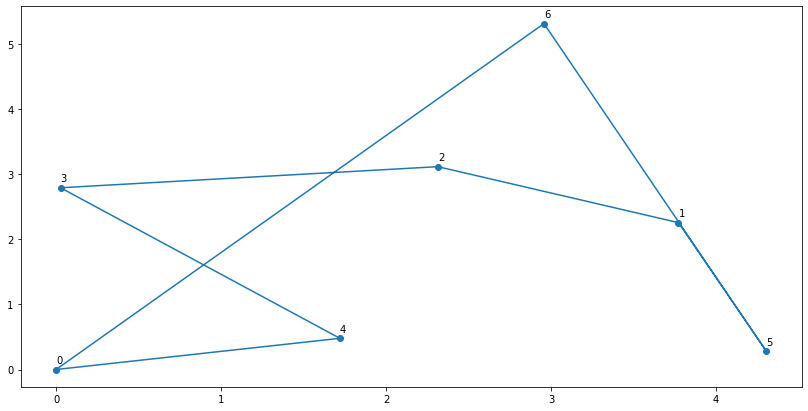

In [ ]:
# Plotting the optimal path

# Transforming the points to the xy plane approximately
xy_cords = np.zeros((n,2))

for i in range(0, n):
    xy_cords[i,0] = distance.distance((points[0][1],0), (points[i][1],0)).km
    xy_cords[i,1] = distance.distance((0,points[0][0]), (0,points[i][0])).km

# Plotting the points
fig, ax = plt.subplots(figsize=(14,7))

for i in range(n):
    ax.annotate(str(i), xy=(xy_cords[i,0], xy_cords[i,1]+0.1))
    
ax.scatter(xy_cords[:,0],xy_cords[:,1])
ax.plot(xy_cords[orden,0], xy_cords[orden,1])

In [ ]:
# Showing the optimal distance
distance = np.sum(np.multiply(C, X.value))
print('The optimal distance is:', np.round(distance,2), 'km')

The optimal distance is: 22.31 km


## Example for three Traveling Salesmen

Continuing with the previous example, now we are going to find the optimal paths (shortest distance) for three salesmen that start from the point of origin (O) and between all of them must go through points A to F and return to point O.

| Point |	Coordinates |
| :----------: | :----------: |
| Origin(O) | (-12.059296, -76.975893) |
| A | (-12.079575, -77.009686) |
| B | (-12.087303, -76.996620) |
| C | (-12.084391, -76.975651) |
| D | (-12.063603, -76.960483) |
| E | (-12.056762, -77.014452) |
| F | (-12.011531, -77.002383) |

In [ ]:
# Solving the integer programming problem

# Defining the variables
X = cp.Variable(C.shape, boolean=True)
u = cp.Variable(n, integer=True)
m = 3
ones = np.ones((n,1))

# Defining the objective function
objective = cp.Minimize(cp.sum(cp.multiply(C, X)))

# Defining the constraints
constraints = []
constraints += [X[0,:] @ ones == m]
constraints += [X[:,0] @ ones == m]
constraints += [X[1:,:] @ ones == 1]
constraints += [X[:,1:].T @ ones == 1]
constraints += [cp.diag(X) == 0]
constraints += [u[1:] >= 2]
constraints += [u[1:] <= n]
constraints += [u[0] == 1]

for i in range(1, n):
    for j in range(1, n):
        if i != j:
            constraints += [u[i]-u[j]+1 <= (n-1)*(1-X[i,j])]

# Solving the problem
prob = cp.Problem(objective, constraints)
prob.solve(verbose=False)

# Transforming the solution to paths
X_sol = np.argwhere(X.value==1)

ruta = {}
for i in range(0, m):
    ruta['Salesman_' + str(i+1)] = [0]
    j = i
    a = 10e10
    while a != 0:
        a = X_sol[j,1]
        ruta['Salesman_' + str(i+1)].append(a)
        j = np.where(X_sol[:,0] == a)
        j = j[0][0]
        a = j

# Showing the paths
for i in ruta.keys():
    print('The path of ' + i + ' is:\n')
    print( ' => '.join(map(str, ruta[i])))
    print('')

The path of Salesman_1 is:

0 => 2 => 1 => 5 => 6 => 0

The path of Salesman_2 is:

0 => 3 => 0

The path of Salesman_3 is:

0 => 4 => 0



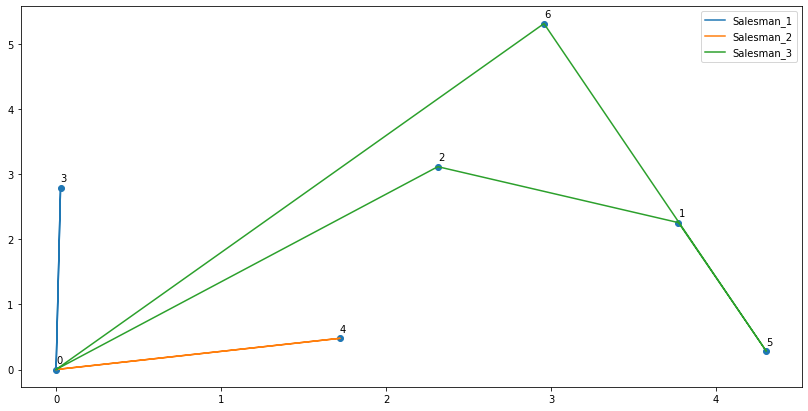

In [ ]:
################################################
# Plotting the optimal path
################################################

# Plotting the points
fig, ax = plt.subplots(figsize=(14,7))

for i in range(n):
    ax.annotate(str(i), xy=(xy_cords[i,0], xy_cords[i,1]+0.1))

ax.scatter(xy_cords[:,0],xy_cords[:,1])
for i in ruta.keys():
    ax.plot(xy_cords[ruta[i],0], xy_cords[ruta[i],1], label = i)
    ax.legend(loc='best')

In [ ]:
# Showing the optimal distance
distance = np.sum(np.multiply(C, X.value))
print('The optimal distance is:', np.round(distance,2), 'km')

The optimal distance is: 22.31 km


It can be observed that depending on the location of the points that salesmen must travel, in terms of distance it may not be optimal to add more salesmen.